In [14]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
from skimage import exposure

In [15]:
def resize_card(image, corners):
    width = int(np.sqrt(np.sum((corners[1] - corners[0]) ** 2)))
    height = int(np.sqrt(np.sum((corners[3] - corners[0]) ** 2)))
    
    target_corners = np.array([[0, 0], [width, 0], [width, height], [0, height]], dtype=np.float32)

    transformation_matrix = cv2.getPerspectiveTransform(corners, target_corners)

    resized_image = cv2.warpPerspective(image, transformation_matrix, (width, height))
    if height>width:
        return cv2.rotate(resized_image,cv2.ROTATE_90_CLOCKWISE)
    return resized_image

In [16]:
def get4Corners(sorted):
    p1 = sorted[0][0]
    p2 = sorted[1][0]
    p3 = sorted[2][0]
    p4 = sorted[3][0]
    centroid = ((p1[0] + p2[0] + p3[0] + p4[0]) / 4, (p1[1] + p2[1] + p3[1] + p4[1]) / 4)
    
    top_left = []
    top_right = []
    bottom_left = []
    bottom_right = []

    for point in [p1, p2, p3, p4]:
        if point[0] < centroid[0] and point[1] < centroid[1]:
            top_left.append(point)
        elif point[0] > centroid[0] and point[1] < centroid[1]:
            top_right.append(point)
        elif point[0] < centroid[0] and point[1] > centroid[1]:
            bottom_left.append(point)
        else:
            bottom_right.append(point)

    while len(top_left) < 1 or len(top_right) < 1 or len(bottom_right) < 1 or len(bottom_left) < 1 :
        if len(top_left) > 1:
            topleft0= top_left[0]
            topleft1= top_left[1]
            top_left.clear()

            if topleft0[0] < topleft1[0]:
                top_left.append(topleft0)
                top_right.append(topleft1)
            else:
                top_left.append(topleft1)
                top_right.append(topleft0)

        if len(bottom_right) > 1:       
            bottomright0= bottom_right[0]
            bottomright1= bottom_right[1]
            bottom_right.clear()

            if bottomright0[0] < bottomright1[0]:
                bottom_left.append(bottomright0)
                bottom_right.append(bottomright1)
            else:
                bottom_left.append(bottomright1)
                bottom_right.append(bottomright0)

        if len(top_right) > 1:
            topright0= top_right[0]
            topright1= top_right[1]
            top_right.clear()

            if topright0[1] < topright1[1]:
                top_right.append(topright0)
                bottom_right.append(topright1)
            else:
                top_right.append(topright1)
                bottom_right.append(topright0)

            
        if len(bottom_left) > 1 :
            bottomleft0= bottom_left[0]
            bottomleft1= bottom_left[1]
            bottom_left.clear()
            if bottomleft0[1] < bottomleft1[1]:
                top_left.append(bottomleft0)
                bottom_left.append(bottomleft1)
            else:
                top_left.append(bottomleft1)
                bottom_left.append(bottomleft0)

    return [top_left,top_right,bottom_left,bottom_right]

In [17]:
def extract_card(image_path):
    image = cv2.imread(image_path)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blurred = cv2.medianBlur(gray, 35)
    blurred = cv2.GaussianBlur(blurred, (7, 7), 10)
    average_intensity = np.mean(gray)
    thresh = 0
    if average_intensity >= 150:
        thresh =average_intensity - 80
    elif average_intensity >= 140:
        thresh = average_intensity - 50
    elif average_intensity >= 110:
        thresh = average_intensity - 20
    elif average_intensity >= 80:
        thresh = average_intensity + 11
    elif average_intensity >= 65:
        thresh = average_intensity + 40
    elif average_intensity >=50:
        thresh = average_intensity + 25
    elif average_intensity >=20:
        thresh = average_intensity + 15
    else:
        thresh = average_intensity - 5
    _, threshold = cv2.threshold(blurred, thresh, 255, cv2.THRESH_BINARY_INV)  
    edges = cv2.Canny(threshold, 15, 30)
    contours, _ = cv2.findContours(edges.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    contours = sorted(contours, key=cv2.contourArea, reverse=True)
    largest_contour = contours[0]
    epsilon = 0.05 * cv2.arcLength(largest_contour, True)
    approx = cv2.approxPolyDP(largest_contour, epsilon, True)
    sorted4 = get4Corners(approx)
    
    top_left = sorted4[0] 
    top_right = sorted4[1]
    bottom_left = sorted4[2]
    bottom_right = sorted4[3]
    corners = np.array([top_left ,top_right, bottom_right, bottom_left], dtype=np.float32)
    resized_image = resize_card(image, corners)
    resized_image = cv2.resize(resized_image,(600,350))
    # new_path = 'cards/' + image_path.split('/')[1]
    # cv2.imwrite(new_path,resized_image)
    return resized_image

In [18]:
def adjust_rotation_bank(src):
    filter = np.array([[-1, -1, -1], [-1, 9, -1], [-1, -1, -1]])
    grayimg = cv2.cvtColor(src, cv2.COLOR_BGR2GRAY)
    grayimg = cv2.filter2D(grayimg,-1,filter)
    refimg = cv2.imread('templates/cards/bankTemplate.jpg')
    grayref = cv2.cvtColor(refimg, cv2.COLOR_BGR2GRAY)
    grayref=cv2.filter2D(grayref,-1,filter)
    grayref = cv2.resize(grayref,(59,38))
    grayscale_8bit = cv2.convertScaleAbs(grayref)
    refimg = cv2.cvtColor(grayscale_8bit, cv2.COLOR_GRAY2BGR)
    refimgReverse = cv2.rotate(refimg,cv2.ROTATE_180)
    color_matched = cv2.cvtColor(grayimg[:150,:300], cv2.COLOR_GRAY2BGR)
    color_matched_reverse = cv2.cvtColor(grayimg[150:,300:], cv2.COLOR_GRAY2BGR)    
    result = cv2.matchTemplate( color_matched, refimg, cv2.TM_CCOEFF)
    reverseResult = cv2.matchTemplate( color_matched_reverse, refimgReverse, cv2.TM_CCOEFF)
    finalRes = src
    result = np.max(result)
    reverseResult = np.max(reverseResult)
    if result < reverseResult:
        finalRes = cv2.rotate(src, cv2.ROTATE_180)
    return finalRes

In [19]:
def adjust_rotation_id(src):
    grayimg = cv2.cvtColor(src.copy(), cv2.COLOR_BGR2GRAY)
    templateCardPic = cv2.imread('templates/cards/templateCard.jpg')
    templateCard = cv2.resize(templateCardPic,(600,350))
    refimg = templateCard
    grayref = cv2.cvtColor(refimg, cv2.COLOR_BGR2GRAY)
    refimgReverse = cv2.rotate(refimg,cv2.ROTATE_180)
    matched_image = exposure.match_histograms(grayimg, grayref)
    grayscale_8bit = cv2.convertScaleAbs(matched_image)
    color_matched = cv2.cvtColor(grayscale_8bit, cv2.COLOR_GRAY2BGR)
    result = cv2.matchTemplate( color_matched[:,220:], refimg[:,220:], cv2.TM_CCOEFF_NORMED)
    reverseResult = cv2.matchTemplate( color_matched[:,0:380], refimgReverse[:,0:380], cv2.TM_CCOEFF_NORMED)
    label = "Bank Card"
    finalRes = src
    if result > 0.22 or reverseResult > 0.22:
        label = "ID Card"
        if result < reverseResult:
                finalRes = cv2.rotate(src, cv2.ROTATE_180)
    else:
        finalRes = adjust_rotation_bank(src)
    
    return [finalRes, label]

In [20]:
def find_numbers(source_image, template, threshold, number, bank):
    if number==6 and bank==1:
        filter = np.array([[-1, -1, -1], [-1, 9, -1], [-1, -1, -1]])
        grayimg = cv2.cvtColor(source_image, cv2.COLOR_BGR2GRAY)
        grayimg = cv2.filter2D(grayimg,-1,filter)
        grayimg = cv2.cvtColor(grayimg, cv2.COLOR_GRAY2BGR)
        grayimg_T = cv2.cvtColor(template, cv2.COLOR_BGR2GRAY)
        grayimg_T = cv2.filter2D(grayimg_T,-1,filter)
        grayimg_T = cv2.cvtColor(grayimg_T, cv2.COLOR_GRAY2BGR)
    else:
        grayimg = cv2.cvtColor(source_image, cv2.COLOR_BGR2GRAY)
        grayimg = cv2.cvtColor(grayimg, cv2.COLOR_GRAY2BGR)
        grayimg_T = cv2.cvtColor(template, cv2.COLOR_BGR2GRAY)
        grayimg_T = cv2.cvtColor(grayimg_T, cv2.COLOR_GRAY2BGR)
        
    result = cv2.matchTemplate(np.array(grayimg) , grayimg_T, cv2.TM_CCOEFF_NORMED)
    locations = np.where(result >= threshold)
    finals = []
    for loc in zip(*locations[::-1]):
        already_added = False
        for final in finals:
            if abs(final[0][0]-loc[0]) < 5 :
                already_added = True
                break
        if already_added:
            continue
        else:
            finals.append([loc,number])
    return finals

In [21]:
def find_id_outter(src,number):
    gray = cv2.cvtColor(src, cv2.COLOR_BGR2GRAY)
    cgray = cv2.cvtColor(gray,cv2.COLOR_GRAY2BGR)
    path = 'templates/numbers/persian/'+str(number)+'.jpg'
    template = cv2.imread(path)
    threshold = 0
    if number == 1:
        threshold = 0.82
    elif number == 9:
        threshold = 0.85
    elif number ==3 or number ==8:
        threshold = 0.8
    elif number == 7 :
        threshold = 0.8
    elif number == 2:
        threshold = 0.85
    elif number == 0:
        threshold = 0.8      
    else:
        threshold = 0.7
    result = find_numbers(cgray, template, threshold, number, None)
    return result

In [22]:
def extract_ID_number(img):
    pic = img[80:110,320:476]
    arr=[]
    for i in range(0,10):
        res =  find_id_outter(pic,i)
        arr.extend(res)
    output=sorted(arr,key=lambda x:x[0][0])
    code_number = ""
    for item in output:
        code_number+=str(item[1])
    return code_number

In [23]:
def find_bank_outter(src,number):
    gray = cv2.cvtColor(src, cv2.COLOR_BGR2GRAY)
    cgray = cv2.cvtColor(gray,cv2.COLOR_GRAY2BGR)
    types = [[0.8, 0.75, 0.7, 0.75, 0.75, 0.75],
             [0.8, 0.8, 0.7, 0.7, 0.7, 0.75,0.7],
             [0.7, 0.65, 0.67, 0.6, 0.7, 0.6],
             [0.8, 0.85, 0.7, 0.7, 0.7, 0.7,0.7, 0.7],
             [0.75, 0.7, 0.7, 0.7, 0.7, 0.7],
             [0.8, 0.82, 0.8, 0.75, 0.75, 0.7, 0.73, 0.73],
             [0.8, 0.75, 0.75, 0.75, 0.75, 0.8, 0.8, 0.7, 0.8, 0.75],   
             [0.8, 0.75, 0.7, 0.75, 0.75],
             [0.7, 0.82, 0.8, 0.8, 0.8, 0.85, 0.7],
             [0.75,0.82,0.7,0.75, 0.75, 0.7, 0.7, 0.6]]
    final_result=[]
    for i in range(len(types[number])):
        bank = i
        path = 'templates/numbers/english/'+str(number)+'/lock/'+str(bank)+'.jpg'
        template = cv2.imread(path)
        threshold = types[number][bank]
        result = find_numbers(cgray, template, threshold, number, bank)
        if len(result) > len(final_result):
            final_result = result             
    return final_result

In [24]:
def extract_Bank_number(img):
    pic = img[:,:]
    arr=[]
    for i in range(0,10):
        res =  find_bank_outter(pic,i)
        arr.extend(res)
    output=sorted(arr,key=lambda x:x[0][0])
    top_left = output[0][0]
    top_left = [top_left[0]+20, top_left[1]+120]
    bottom_right = output[len(output)-1][0] 
    bottom_right = [bottom_right[0]+65, bottom_right[1]+165]
    code_number = ""
    for item in output:
        code_number+=str(item[1])
    return [code_number, [top_left,bottom_right]]

In [25]:
def predict(path):
    resized_image = extract_card(path)
    [rotated_image, label] = adjust_rotation_id(resized_image)
    title = ""
    if label == "ID Card":
        cv2.rectangle(rotated_image,(320,80), (475,110), (255,0,0),1)
        code = extract_ID_number(rotated_image)
        title = label + "/ Persian Numbers / " + code
    else:
        [code, [top_left, bottom_right]] = extract_Bank_number(rotated_image[125:290,30:580])
        cv2.rectangle(rotated_image, top_left, bottom_right, (0,255,0),2)
        code = ' '.join([code[i:i+4] for i in range(0,len(code), 4)])
        title = label + "/ English Numbers / " + code 
              
    plt.imshow(cv2.cvtColor(rotated_image, cv2.COLOR_BGR2RGB))
    plt.title(title), plt.xticks([]), plt.yticks([])
    plt.show()  
    
    return title    
    

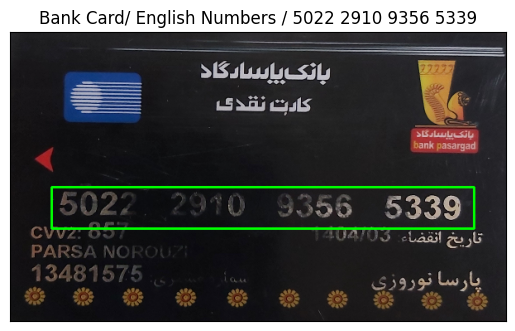

Bank Card/ English Numbers / 5022 2910 9356 5339


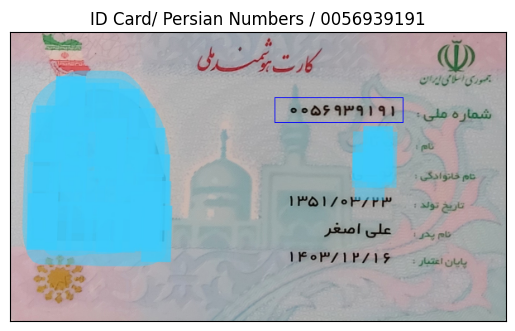

ID Card/ Persian Numbers / 0056939191


KeyboardInterrupt: 

In [26]:
directory = "inputs/"
for filename in os.listdir(directory):
    image_path = os.path.join(directory, filename)
    prediction = predict(image_path)
    print(prediction)